## Imports

In [1]:
%env LIBSUMO_AS_TRACI=1
!echo $LIBSUMO_AS_TRACI

env: LIBSUMO_AS_TRACI=1
1


In [3]:
from importlib import reload
import sys
import os

from typing import Any
from typing import Dict

current_dir = os.getcwd()

sys.path.append(os.path.join(current_dir, '..', '..'))

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# Traffic Signal Controller Reinforcement Learning Modules

import tscRL.environments.environment
reload(tscRL.environments.environment)
from tscRL.environments.environment import SumoEnvironment, TrafficLight as tl

import tscRL.agents.dqn_agent
reload(tscRL.agents.dqn_agent)
from tscRL.agents.ql_agent import QLAgent
from tscRL.agents.dqn_agent import DQNAgent
# Include sumo-tools directory
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
    


/home/juanma/Dev/tlc-rl/code/experiments/dqn_experiment/../..


In [3]:
sumoCfgFile_unbalanced = os.path.abspath(os.path.join(current_dir, '../../../nets/2x2_intersection/intersection_unbalanced.sumocfg'))

In [42]:
env = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unbalanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    discreteIntervals=8,
    maxLaneValue=500, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=False,
    simTime=43800, 
    sumoLog=False
)


In [5]:
from stable_baselines3.common.env_checker import check_env 
check_env(env)

In [104]:
dqn_agent = DQNAgent(env=env, learningRate=0.01, batchSize=64, explorationFraction=0.2, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [74]:
dqn_agent.learn(episodes=2)

Loading state from '/home/juanma/Dev/tlc-rl/code/tscRL/.states/initialState.xml' ... ---------------------------------------
| rollout/                 |          |
|    ep_len_mean           | 8.64e+03 |
|    ep_rew_mean           | -215     |
|    exploration_rate      | 0.05     |
| time/                    |          |
|    episode_time          | 41.4     |
|    episodes              | 1        |
|    fps                   | 208      |
|    time_elapsed          | 41       |
|    total_timesteps       | 8641     |
| train/                   |          |
|    learning_rate         | 0.01     |
|    loss                  | 148      |
|    mean_acc_waiting_time | 20.9     |
|    mean_waiting_time     | 6.96     |
|    n_updates             | 8540     |
---------------------------------------
---------------------------------------
| rollout/                 |          |
|    ep_len_mean           | 8.64e+03 |
|    ep_rew_mean           | -792     |
|    exploration_rate      | 0.05  

In [75]:
env.discreteClass.get_max_encoded_value()

4981.0

In [4]:
M=2500
I=20

In [77]:
from tscRL.util.discrete import Discrete

encoder = Discrete(I,M)

In [78]:
x_values = np.linspace(0, M+M*0.5, M)

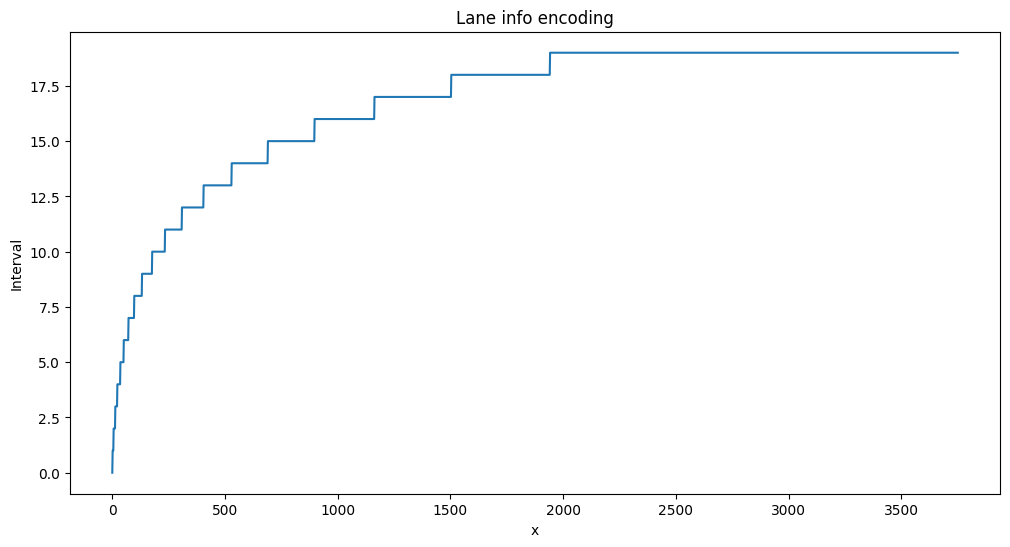

In [80]:
i_values = [encoder.log_interval(x) for x in x_values]

plt.figure(figsize=(12, 6))
plt.plot(x_values, i_values)
plt.xlabel('x')
plt.ylabel('Interval')
plt.title('Lane info encoding')
plt.show()

In [8]:
import optuna
reload(optuna)
from optuna.pruners import MedianPruner
from optuna.samplers import RandomSampler

from tscRL.agents.callbacks import TrialCallback

import gymnasium as gym
import torch
from stable_baselines3.common.monitor import Monitor

In [14]:
from tscRL.agents import callbacks
reload(callbacks)

<module 'tscRL.agents.callbacks' from '/home/juanma/Dev/tlc-rl/code/experiments/../tscRL/agents/callbacks.py'>

In [7]:
DEFAULT_HYPERPARAMS = {
    "env": env
}

In [16]:
def sample_dqn_params(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    buffer_size = trial.suggest_categorical("buffer_size", [100000, 500000, 1000000])
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.1, 0.6)
    target_update_interval = trial.suggest_categorical("target_update_interval", [1000, 5000, 10000])
    layer_size = trial.suggest_categorical("layer", [32, 64, 128])
    net_arch = (layer_size, layer_size)

    hyperparams = {
        "learningRate": learning_rate,
        "batchSize": batch_size,
        "bufferSize": buffer_size,
        "explorationFraction": exploration_fraction,
        "targetUpdateInterval": target_update_interval,
        "netArch": net_arch
    }

    return hyperparams

In [6]:
N_EVAL_EPISODES = 50


In [19]:
def objective(trial: optuna.Trial):
    kwargs = DEFAULT_HYPERPARAMS.copy()
    kwargs.update(sample_dqn_params(trial))
    kwargs["callback"] = TrialCallback(trial=trial, n_eval_episodes=N_EVAL_EPISODES, min_trial_fract=0.75, rewards_window_size=6, prune=False )

    dqn_agent = DQNAgent(**kwargs)
    
    nan_encountered = False
    try:
        dqn_agent.learn(episodes=N_EVAL_EPISODES)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")
    if dqn_agent.callback.is_pruned:
        raise optuna.exceptions.TrialPruned()
    last_crs = dqn_agent.callback.last_cumulative_rewards
    return np.mean(last_crs)

In [113]:
N_TRIALS=5

In [ ]:
pruner = MedianPruner()

study = optuna.create_study(pruner=pruner, direction="maximize")

try:
    study.optimize(objective, n_trials=N_TRIALS)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

/tmp/ipykernel_403787/3605291357.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study2)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

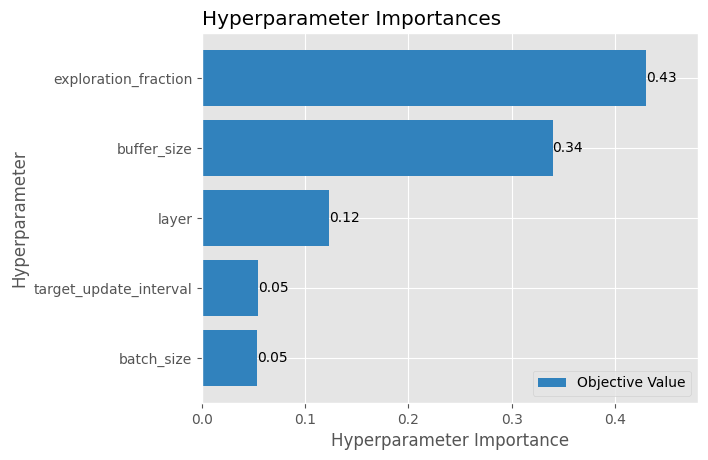

In [14]:
optuna.visualization.matplotlib.plot_param_importances(study2)

In [22]:
def sample_dqn_params2(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """

    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    buffer_size = trial.suggest_categorical("buffer_size", [100000, 500000, 1000000])
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.1, 0.6)
    target_update_interval = trial.suggest_categorical("target_update_interval", [1000, 5000, 10000])
    layer_size = trial.suggest_categorical("layer", [32, 64, 128])
    net_arch = (layer_size, layer_size)

    hyperparams = {
        "batchSize": batch_size,
        "bufferSize": buffer_size,
        "explorationFraction": exploration_fraction,
        "targetUpdateInterval": target_update_interval,
        "netArch": net_arch
    }

    return hyperparams

In [23]:
def objective2(trial: optuna.Trial):
    kwargs = DEFAULT_HYPERPARAMS.copy()
    kwargs.update(sample_dqn_params2(trial))
    kwargs["learningRate"] = 0.01
    kwargs["callback"] = TrialCallback(trial=trial, n_eval_episodes=N_EVAL_EPISODES, min_trial_fract=0.75, rewards_window_size=6, prune=False )

    dqn_agent = DQNAgent(**kwargs)
    
    nan_encountered = False
    try:
        dqn_agent.learn(episodes=N_EVAL_EPISODES)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")
    if dqn_agent.callback.is_pruned:
        raise optuna.exceptions.TrialPruned()
    last_crs = dqn_agent.callback.last_cumulative_rewards
    return np.mean(last_crs)

In [145]:
study2 = optuna.create_study(pruner=pruner, direction="maximize")

try:
    study2.optimize(objective2, n_trials=5)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study2.trials))

print("Best trial:")
trial = study2.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-26 04:18:48,313] A new study created in memory with name: no-name-ba12291b-55cf-4082-949e-a0d10b8f05f9
[I 2024-07-26 04:54:15,830] Trial 0 finished with value: -375.0 and parameters: {'batch_size': 32, 'buffer_size': 1000000, 'exploration_fraction': 0.5801808930035376, 'target_update_interval': 1000, 'layer': 64}. Best is trial 0 with value: -375.0.
[I 2024-07-26 05:28:16,784] Trial 1 finished with value: -12732.3330078125 and parameters: {'batch_size': 64, 'buffer_size': 100000, 'exploration_fraction': 0.13673504341039236, 'target_update_interval': 10000, 'layer': 32}. Best is trial 0 with value: -375.0.
[I 2024-07-26 06:04:56,387] Trial 2 finished with value: -10761.8330078125 and parameters: {'batch_size': 64, 'buffer_size': 500000, 'exploration_fraction': 0.12318374427181014, 'target_update_interval': 10000, 'layer': 64}. Best is trial 0 with value: -375.0.
[I 2024-07-26 06:38:52,716] Trial 3 finished with value: -7122.33349609375 and parameters: {'batch_size': 64, 'buff

Number of finished trials:  10
Best trial:
  Value:  -195.5
  Params: 
    batch_size: 64
    buffer_size: 500000
    exploration_fraction: 0.40088521490348694
    target_update_interval: 10000
    layer: 32


In [148]:
#%store study2

Stored 'study2' (Study)


/tmp/ipykernel_308069/3605291357.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study2)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

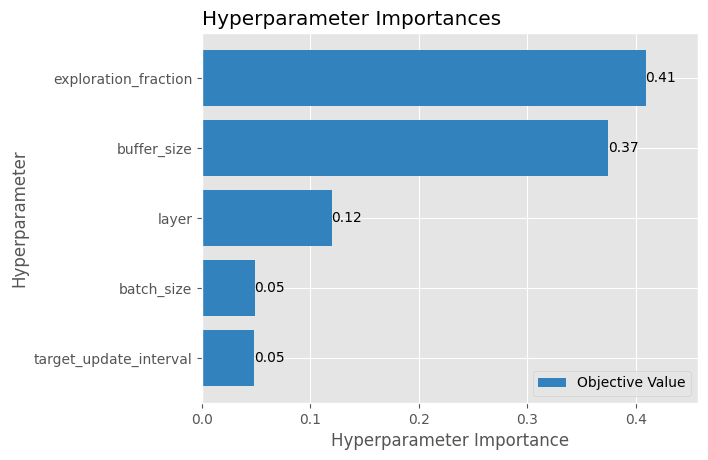

In [24]:
optuna.visualization.matplotlib.plot_param_importances(study2)

In [ ]:
try:
    study2.optimize(objective2, n_trials=5)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study2.trials))

print("Best trial:")
trial = study2.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [43]:
fig = optuna.visualization.plot_param_importances(study2)
fig.show()

In [49]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.show()

In [54]:
for i in [1,2,3,4,5,6,12]:
    print("Trial " + str(i) + ". Value= " + str(study.trials[i].value)  + ". Params: ", end="")
    print(study.trials[i].params)

Trial 1. Value= -12732.3330078125. Params: {'batch_size': 64, 'buffer_size': 100000, 'exploration_fraction': 0.13673504341039236, 'target_update_interval': 10000, 'layer': 32}
Trial 2. Value= -10761.8330078125. Params: {'batch_size': 64, 'buffer_size': 500000, 'exploration_fraction': 0.12318374427181014, 'target_update_interval': 10000, 'layer': 64}
Trial 3. Value= -7122.33349609375. Params: {'batch_size': 64, 'buffer_size': 500000, 'exploration_fraction': 0.18902142646582046, 'target_update_interval': 5000, 'layer': 32}
Trial 4. Value= -6371.16650390625. Params: {'batch_size': 32, 'buffer_size': 100000, 'exploration_fraction': 0.23311633233412357, 'target_update_interval': 1000, 'layer': 32}
Trial 5. Value= -2961.666748046875. Params: {'batch_size': 64, 'buffer_size': 500000, 'exploration_fraction': 0.2895164402920485, 'target_update_interval': 5000, 'layer': 128}
Trial 6. Value= -10350.3330078125. Params: {'batch_size': 64, 'buffer_size': 100000, 'exploration_fraction': 0.28447155579

In [58]:
for i in [0,7,8,9,10,11]:
    print("Trial " + str(i) + ". Value= " + str(study.trials[i].value)  + ". Params: ", end="")
    print(study.trials[i].params)

Trial 0. Value= -375.0. Params: {'batch_size': 32, 'buffer_size': 1000000, 'exploration_fraction': 0.5801808930035376, 'target_update_interval': 1000, 'layer': 64}
Trial 7. Value= -580.6666870117188. Params: {'batch_size': 32, 'buffer_size': 1000000, 'exploration_fraction': 0.138535451329687, 'target_update_interval': 1000, 'layer': 128}
Trial 8. Value= -591.0. Params: {'batch_size': 32, 'buffer_size': 1000000, 'exploration_fraction': 0.4182892201681856, 'target_update_interval': 5000, 'layer': 32}
Trial 9. Value= -195.5. Params: {'batch_size': 64, 'buffer_size': 500000, 'exploration_fraction': 0.40088521490348694, 'target_update_interval': 10000, 'layer': 32}
Trial 10. Value= -610.6666870117188. Params: {'batch_size': 64, 'buffer_size': 500000, 'exploration_fraction': 0.4322869611624071, 'target_update_interval': 10000, 'layer': 32}
Trial 11. Value= -353.8333435058594. Params: {'batch_size': 32, 'buffer_size': 1000000, 'exploration_fraction': 0.5666400711093516, 'target_update_interva

Se puede observar como un exploration_fraction bajo produce una divergencia de la solución

In [64]:
def sample_dqn_params3(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """

    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    buffer_size = trial.suggest_categorical("buffer_size", [500000, 1000000])
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.4, 0.75)
    target_update_interval = trial.suggest_categorical("target_update_interval", [1000, 5000, 10000])
    layer_size = trial.suggest_categorical("layer", [32, 64,128])
    net_arch = (layer_size, layer_size)

    hyperparams = {
        "batchSize": batch_size,
        "bufferSize": buffer_size,
        "explorationFraction": exploration_fraction,
        "targetUpdateInterval": target_update_interval,
        "netArch": net_arch
    }

    return hyperparams

In [93]:
def objective3(trial: optuna.Trial):
    kwargs = DEFAULT_HYPERPARAMS.copy()
    kwargs.update(sample_dqn_params3(trial))
    kwargs["learningRate"] = 0.01
    kwargs["callback"] = TrialCallback(trial=trial, n_eval_episodes=N_EVAL_EPISODES, min_trial_fract=0.9, rewards_window_size=6, prune=False, verbose=True)

    dqn_agent = DQNAgent(**kwargs)
    
    nan_encountered = False
    try:
        dqn_agent.learn(episodes=N_EVAL_EPISODES)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")
    if dqn_agent.callback.is_pruned:
        raise optuna.exceptions.TrialPruned()
    last_crs = dqn_agent.callback.last_cumulative_rewards
    return np.mean(last_crs)

In [ ]:
pruner = MedianPruner()
if "study3" not in globals():
    study3 = optuna.create_study(pruner=pruner, direction="maximize")
try:
    study3.optimize(objective3, n_trials=5)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study3.trials))

print("Best trial:")
trial = study3.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [70]:
#%store study3

Stored 'study3' (Study)


In [1]:
%store -r

In [ ]:
try:
    study3.optimize(objective3, n_trials=5)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study3.trials))

print("Best trial:")
trial = study3.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [102]:
fig = optuna.visualization.plot_param_importances(study3)
fig.show()

In [134]:
fig = optuna.visualization.plot_slice(study3, params=["layer", "target_update_interval", "exploration_fraction"])
fig.show()



In [110]:
for i in [1,8,16]:
    print("Trial " + str(i) + ". Value= " + str(study3.trials[i].value)  + ". Params: ", end="")
    print(study3.trials[i].params)

Trial 1. Value= -3193.166748046875. Params: {'batch_size': 64, 'buffer_size': 500000, 'exploration_fraction': 0.5164681074038905, 'target_update_interval': 10000, 'layer': 64}
Trial 8. Value= -1897.8333740234375. Params: {'batch_size': 64, 'buffer_size': 1000000, 'exploration_fraction': 0.527167820611655, 'target_update_interval': 10000, 'layer': 128}
Trial 16. Value= -4000.666748046875. Params: {'batch_size': 32, 'buffer_size': 500000, 'exploration_fraction': 0.4643547294891628, 'target_update_interval': 5000, 'layer': 128}


In [82]:
for i in [0,2,3,4,7,9,10,11,12,13,14,15]:
    print("Trial " + str(i) + ". Value= " + str(study3.trials[i].value)  + ". Params: ", end="")
    print(study3.trials[i].params)

Trial 0. Value= -540.3333129882812. Params: {'batch_size': 64, 'buffer_size': 500000, 'exploration_fraction': 0.4929594500998701, 'target_update_interval': 5000, 'layer': 32}
Trial 2. Value= -313.8333435058594. Params: {'batch_size': 32, 'buffer_size': 1000000, 'exploration_fraction': 0.5257492875414552, 'target_update_interval': 10000, 'layer': 32}
Trial 3. Value= -382.0. Params: {'batch_size': 64, 'buffer_size': 1000000, 'exploration_fraction': 0.6478428976322228, 'target_update_interval': 5000, 'layer': 64}
Trial 4. Value= -736.6666870117188. Params: {'batch_size': 64, 'buffer_size': 1000000, 'exploration_fraction': 0.5628702954130727, 'target_update_interval': 10000, 'layer': 128}
Trial 7. Value= -815.5. Params: {'batch_size': 64, 'buffer_size': 1000000, 'exploration_fraction': 0.6838573178541161, 'target_update_interval': 5000, 'layer': 32}
Trial 9. Value= -135.5. Params: {'batch_size': 64, 'buffer_size': 500000, 'exploration_fraction': 0.4276527761812984, 'target_update_interval'

In [131]:
df_study = study.trials_dataframe()
df_study.to_csv('parametersStudy.csv', index=False)

In [132]:
df_study3 = study3.trials_dataframe()
df_study3.to_csv('parametersStudy3.csv', index=False)

In [24]:
def sample_dqn_params4(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    buffer_size = trial.suggest_categorical("buffer_size", [500000, 1000000])

    hyperparams = {
        "learningRate": learning_rate,
        "batchSize": batch_size,
        "bufferSize": buffer_size
    }

    return hyperparams

In [22]:
N_EVAL_EPISODES_2 = 75

In [25]:
def objective4(trial: optuna.Trial):
    kwargs = DEFAULT_HYPERPARAMS.copy()
    kwargs.update(sample_dqn_params4(trial))
    kwargs["explorationFraction"] = 0.5
    kwargs["targetUpdateInterval"] = 1000
    kwargs["netArch"] = (32, 32)
    kwargs["callback"] = TrialCallback(trial=trial, n_eval_episodes=N_EVAL_EPISODES_2, min_trial_fract=0.9, rewards_window_size=10, prune=False, verbose=True)

    dqn_agent = DQNAgent(**kwargs)
    
    nan_encountered = False
    try:
        dqn_agent.learn(episodes=N_EVAL_EPISODES_2)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")
    if dqn_agent.callback.is_pruned:
        raise optuna.exceptions.TrialPruned()
    last_crs = dqn_agent.callback.last_cumulative_rewards
    return np.mean(last_crs)

In [ ]:
pruner = MedianPruner()

study4 = optuna.create_study(pruner=pruner, direction="maximize")
for _ in range(5):
    study4.optimize(objective4, n_trials=1)
    %store study4


print("Number of finished trials: ", len(study4.trials))

print("Best trial:")
trial = study4.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
for _ in range(5):
    study4.optimize(objective4, n_trials=1)
    %store study4


print("Number of finished trials: ", len(study4.trials))

print("Best trial:")
trial = study4.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [41]:
df_study4 = study4.trials_dataframe()
df_study4.to_csv('parametersStudy4.csv', index=False)

In [37]:
fig = optuna.visualization.plot_param_importances(study4)
fig.show()

In [38]:
fig = optuna.visualization.plot_slice(study4)
fig.show()

In [40]:
fig = optuna.visualization.plot_intermediate_values(study4)
fig.show()


In [6]:
env = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unbalanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    discreteIntervals=I,
    maxLaneValue=M, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=False,
    simTime=43800, 
    sumoLog=False
)

In [7]:
dqn_agent = DQNAgent(
    env=env,
    learningRate=0.001,
    batchSize=64,
    explorationFraction=0.5,
    verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
print(dqn_agent.model.get_env())

In [5]:
MODEL_ID = "dqn_unbalanced"

In [ ]:
dqn_agent.learn(100)
dqn_agent.model.save(MODEL_ID)

In [6]:
env = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unbalanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=True,
    edges=False,
    discreteIntervals=I,
    maxLaneValue=M, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=False,
    simTime=43800, 
    sumoLog=False
)

Fontconfig warning: "/usr/share/fontconfig/conf.avail/05-reset-dirs-sample.conf", line 6: unknown element "reset-dirs"


In [7]:
dqn_agent_ = DQNAgent(
    env=env,
    learningRate=0.001,
    batchSize=64,
    explorationFraction=0.5,
    verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [8]:
modelFileLocation = os.path.join(os.getcwd(), MODEL_ID)
modelFileLocation

'/home/juanma/Dev/tlc-rl/code/experiments/dqn_experiment/dqn_unbalanced'

In [11]:
env.close()

In [9]:
dqn_agent_.loadModel(modelFileLocation, env)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
dqn_agent_.run()

KeyboardInterrupt: 

In [31]:
metrics_dqn_unbalanced = dqn_agent.callback.get_metrics()
df_dqn_unbalanced = pd.DataFrame(metrics_dqn_unbalanced)
df_dqn_unbalanced.to_csv('df_dqn_unbalanced.csv', index=False) 


,episode,mean_waiting_time,mean_acc_waiting_time,cumulative_reward,time,loss_value
0,0,20.058519,78.071036,-9895.0,76.985581,412.028503
1,1,18.646267,73.885071,-7079.0,72.525040,382.234558
2,2,18.249723,71.340407,-12225.0,66.275265,254.116699
3,3,17.938920,73.257218,-13086.0,60.080994,248.632675
4,4,16.394279,65.850465,-10972.0,53.760410,336.834412
...,...,...,...,...,...,...
96,96,1.759673,3.207850,-342.0,35.782528,57.824738
97,97,1.617916,2.727041,-22.0,35.234205,113.654419
98,98,1.634682,2.818807,-114.0,35.465969,89.036789
99,99,1.717028,3.190134,-9.0,35.409652,54.534019


In [1]:
def serializeRuns(runs, fileName):
    rows = []
    # Iterar sobre la lista de diccionarios
    for run, entry in enumerate(runs):
        for episode, mwt, mawt, cr, t in zip(entry["episode"], entry["mean_waiting_time"], entry["mean_acc_waiting_time"], entry["cumulative_reward"], entry["time"]):
            rows.append({"run": run, "episode": episode, "mean_waiting_time": mwt, "mean_acc_waiting_time": mawt, "cumulative_reward": cr, "time": t})

    # Crear el DataFrame
    df = pd.DataFrame(rows)
    df.to_csv(fileName, index=False)
    return df


In [13]:
df_balanced_unb_ftl = pd.read_csv("df_unbalanced_ftl.csv")
df_dqn_unbalanced = pd.read_csv("df_dqn_unbalanced.csv")

In [14]:
print("Mean cumulative waiting time in fixed TLC: " + str(df_balanced_unb_ftl["mean_acc_waiting_time"].mean()))
print("Mean cumulative waiting time in final trained DQNTLC: " + str(df_dqn_unbalanced.loc[df_dqn_unbalanced['episode'] == 100, 'mean_acc_waiting_time'].values[0]))

Mean cumulative waiting time in fixed TLC: 17.56562888590659
Mean cumulative waiting time in final trained DQNTLC: 3.1099849093489484


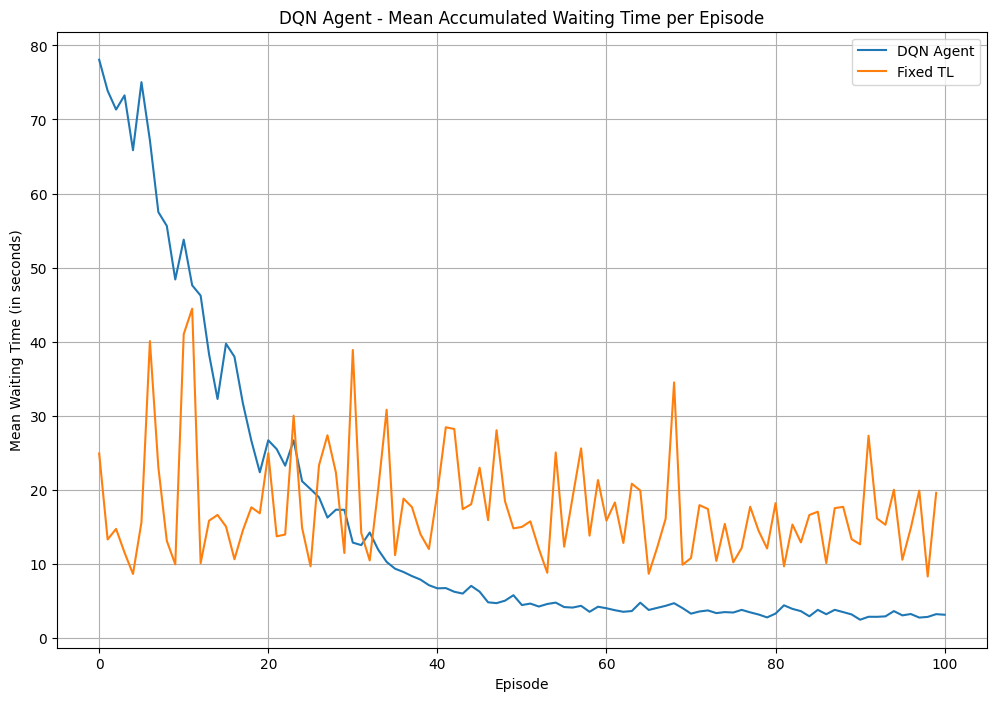

In [16]:

plt.figure(figsize=(12, 8))

plt.plot(df_dqn_unbalanced["episode"], df_dqn_unbalanced['mean_acc_waiting_time'], label="DQN Agent")

plt.plot(df_balanced_unb_ftl["episode"], df_balanced_unb_ftl['mean_acc_waiting_time'], label="Fixed TL")

plt.xlabel('Episode', fontsize=20)
plt.ylabel('Mean Waiting Time (in seconds)')
plt.title('DQN Agent - Mean Accumulated Waiting Time per Episode')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_673279/291768788.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


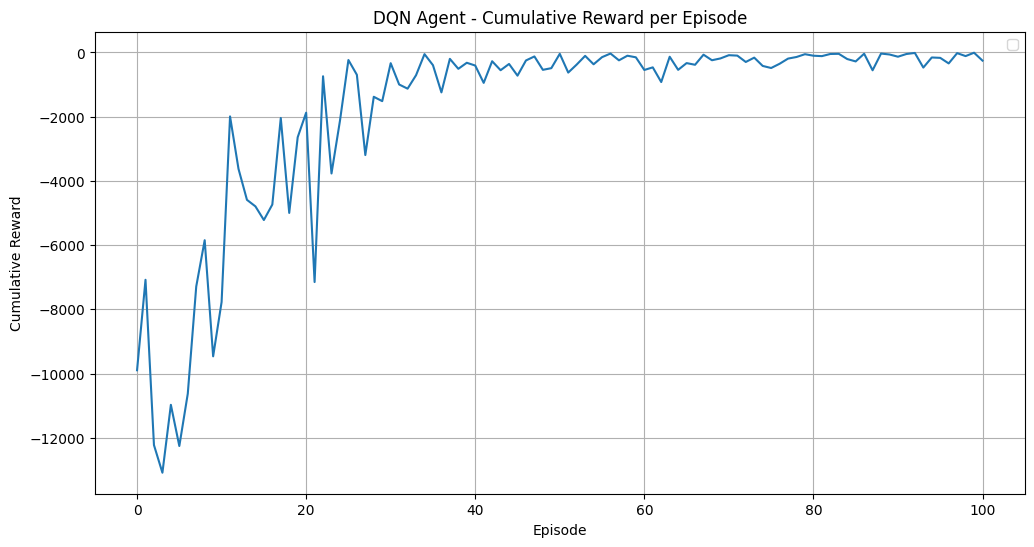

In [29]:
plt.figure(figsize=(12, 6))

plt.plot(df_dqn_unbalanced["episode"], df_dqn_unbalanced['cumulative_reward'])

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('DQN Agent - Cumulative Reward per Episode')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_673279/1631787308.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


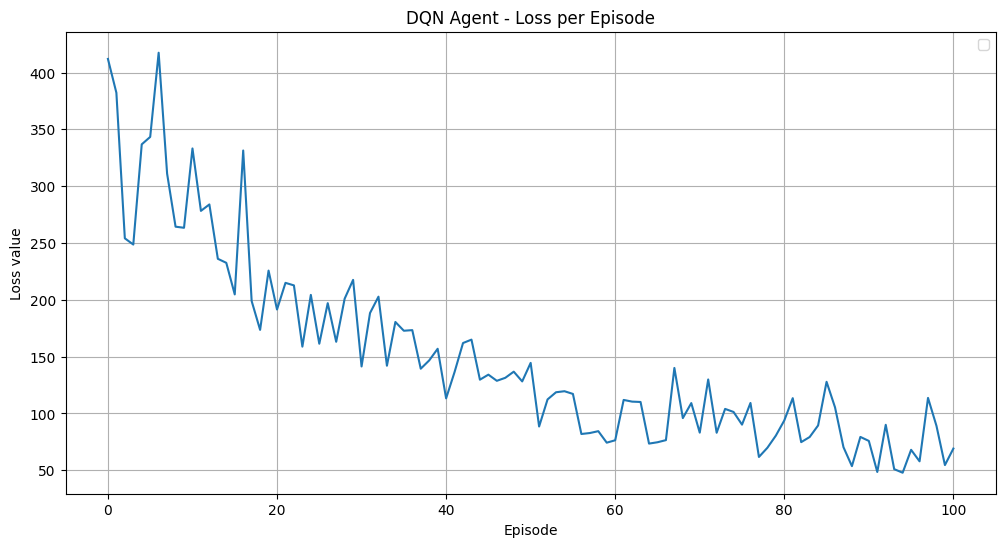

In [33]:
plt.figure(figsize=(12, 6))

plt.plot(df_dqn_unbalanced["episode"], df_dqn_unbalanced['loss_value'])

plt.xlabel('Episode')
plt.ylabel('Loss value')
plt.title('DQN Agent - Loss per Episode')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
sumoCfgFile_balanced = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/intersection_balanced.sumocfg'))

In [5]:
env_balanced = SumoEnvironment(
    sumocfgFile=sumoCfgFile_balanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    discreteIntervals=I,
    maxLaneValue=M, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=False,
    simTime=43800, 
    sumoLog=False
)

NameError: name 'sumoCfgFile_balanced' is not defined

In [ ]:
dqn_agent = DQNAgent(
    env=env_balanced,
    learningRate=0.001,
    batchSize=64,
    explorationFraction=0.5,
    verbose=1
)
dqn_agent.learn(episodes=100)
metrics = dqn_agent.callback.get_metrics()

In [58]:
df_balanced = pd.DataFrame(metrics)
df_balanced.to_csv("dqn_agent_balanced", index=False)

In [4]:

from tscRL.agents import fixedTL_agent as ftl_agent

In [9]:
ftl_agent.FixedTLAgent

tscRL.agents.fixedTL_agent.FixedTLAgent

In [19]:
sumoCfgFile_balanced = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/intersection_balanced.sumocfg'))

In [7]:
env_unbalanced_ftl = SumoEnvironment(
    sumocfgFile=sumoCfgFile_unbalanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    discreteIntervals=I,
    maxLaneValue=M, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=True,
    simTime=43800, 
    sumoLog=False
)

In [20]:
env_balanced_ftl = SumoEnvironment(
    sumocfgFile=sumoCfgFile_balanced,
    deltaTime=5,
    yellowTime=4,
    minGreenTime=10,
    gui=False,
    edges=False,
    discreteIntervals=I,
    maxLaneValue=M, 
    laneInfo="waitingTime",
    rewardFn="diff_cumulativeWaitingTime",
    fixedTL=True,
    simTime=43800, 
    sumoLog=False
)

In [ ]:
ftlAgent = ftl_agent.FixedTLAgent(environment=env_unbalanced_ftl, episodes=100)
metrics_unb_ftl = ftlAgent.run()

In [ ]:
ftlAgent = ftl_agent.FixedTLAgent(environment=env_balanced_ftl, episodes=100)
metrics_bal_ftl = ftlAgent.run()

In [23]:
df_unbalanced_ftl = pd.DataFrame(metrics_unb_ftl)
df_unbalanced_ftl.to_csv('df_unbalanced_ftl.csv', index=False)

In [34]:
float(df_balanced_ftl["mean_acc_waiting_time"].mean())

8.035973761747103

In [33]:
float(df_unbalanced_ftl["mean_acc_waiting_time"].mean())

17.56562888590659

In [ ]:
float(df_balanced_ftl["mean_acc_waiting_time"].mean())

In [32]:
df_unbalanced_ftl=pd.read_csv("df_unbalanced_ftl.csv")
df_balanced_ftl=pd.read_csv("df_balanced_ftl.csv")

In [24]:
df_balanced_ftl = pd.DataFrame(metrics_bal_ftl)
df_balanced_ftl.to_csv('df_balanced_ftl.csv', index=False)

In [40]:
df_balanced_ftl["mean_acc_waiting_time"].mean()

np.float64(8.035973761747103)

In [41]:
df_dqn_balanced[df_dqn_balanced['episode'] == 99]["mean_acc_waiting_time"]

99    3.79236
Name: mean_acc_waiting_time, dtype: float64

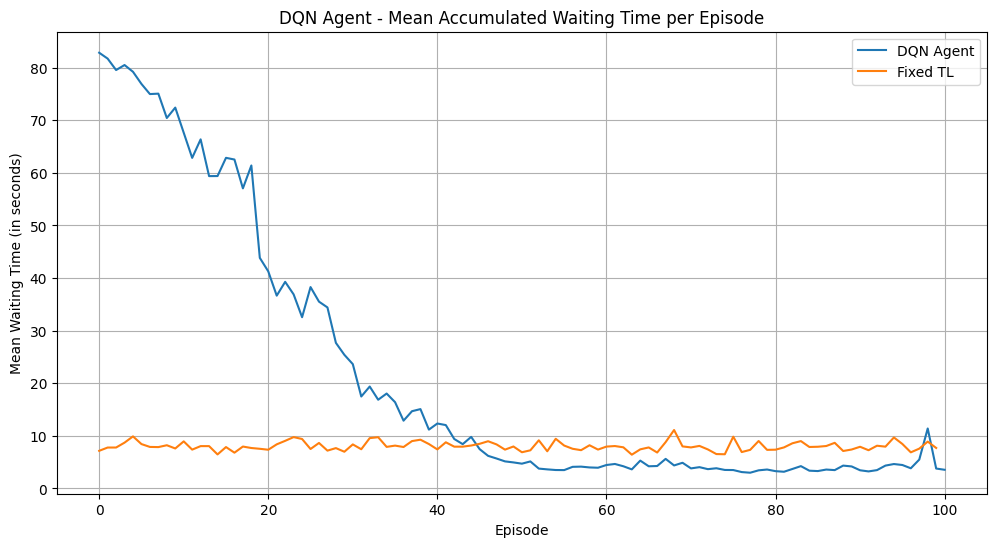

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df_dqn_balanced["episode"], df_dqn_balanced['mean_acc_waiting_time'], label="DQN Agent")
plt.plot(df_balanced_ftl["episode"], df_balanced_ftl['mean_acc_waiting_time'], label="Fixed TL")
plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time (in seconds)')
plt.title('DQN Agent - Mean Accumulated Waiting Time per Episode')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_533914/3695520420.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


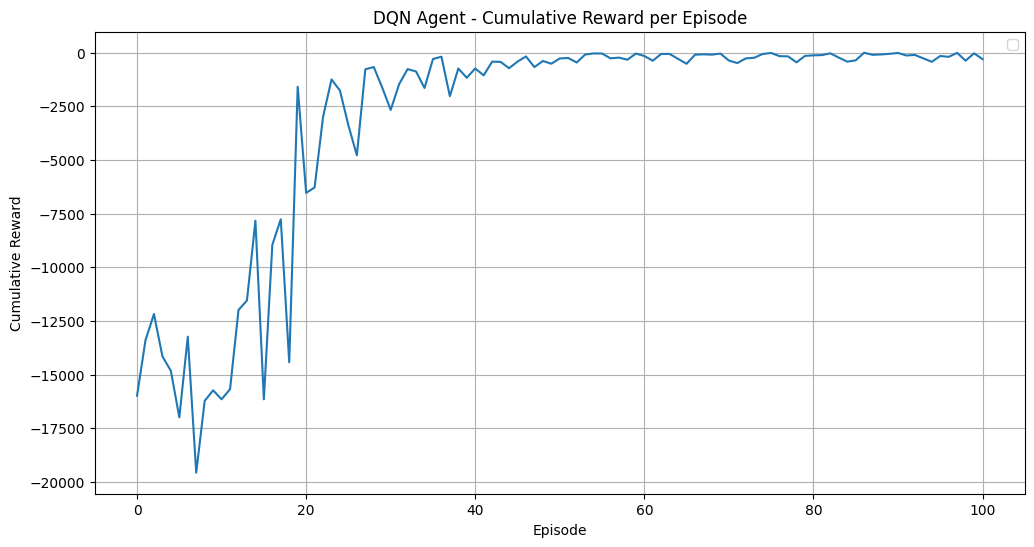

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(df_balanced["episode"], df_balanced['cumulative_reward'])

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('DQN Agent - Cumulative Reward per Episode')
plt.legend()
plt.grid(True)
plt.show()